# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

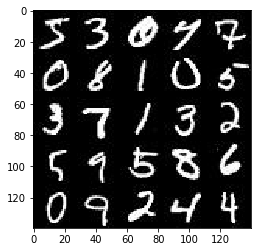

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

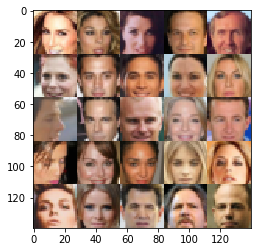

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_images')
    z_vect = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_vect')
    learnrate = tf.placeholder(tf.float32, name='learnrate')
    return input_images, z_vect, learnrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # This has to work with any generic dataset that we throw in. Currently, we either have
        # MNIST, which is 28x28, single channel and CELEBA, which is 178x218, 3 channel
        # But we're in luck! The parent function PROMISED to provide us data as 28x28x3 channel Yay!
        # Discriminator goes from image to single binary value (real/not real)
        # Input layer is 28x28xn. Not a lot we can do with that from an "evenly divisible number of layers" sense
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True) # help with training
        relu2 = tf.maximum(alpha * bn2, bn2) # leaky relu
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.02
    # Following the logic in the DCGAN example, generator variables are set to reuse when it's not training
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x64 now
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x32 now
        
        # Output layer
        # A stride of 1 will keep the overall shape the same, we just need to set the number
        # of filters to the desired number of output channels
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits) * 0.5 # tanh scales to the range -1 to 1, but we need -0.5 to 0.5
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Follows what we did for the DCGAN exercise
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_channels = len(data_image_mode)
    image_height = data_shape[1]
    image_width = data_shape[2]
    print("Using images of size (",image_width, ", ",image_height, ", ",image_channels,")")
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        print("Complete.")
        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Using images of size ( 28 ,  28 ,  1 )
Epoch 1/2... Discriminator Loss: 0.8469... Generator Loss: 0.7410
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 0.9834
Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 0.9650
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.3006
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 1.1866
Epoch 1/2... Discriminator Loss: 0.4879... Generator Loss: 1.4592
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.2977
Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 0.9489


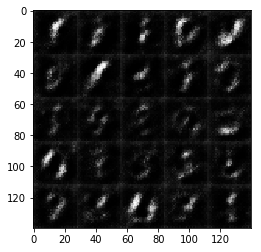

Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 0.6460
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 1.0982
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.8350
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.9692
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.6643... Generator Loss: 0.3834
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.8228


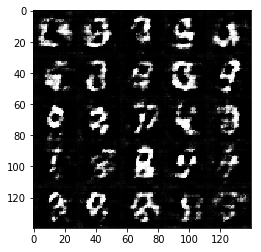

Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.9091
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 0.9682
Complete.


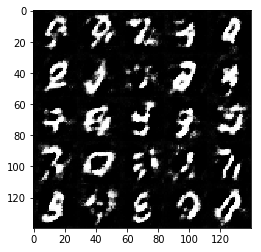

In [34]:
batch_size = 500
z_dim = 784
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Using images of size ( 28 ,  28 ,  3 )
Epoch 1/1... Discriminator Loss: 1.7661... Generator Loss: 0.2727
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 1.6386
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 0.9670


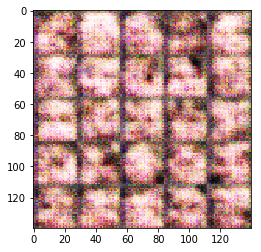

Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 1.9301
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.6580
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 0.9345


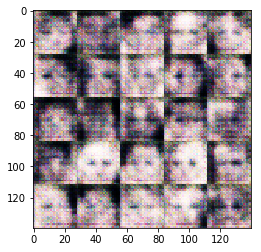

Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.8855


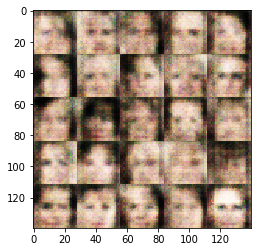

Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 0.9933


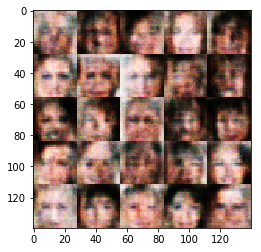

Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.1126
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.4480


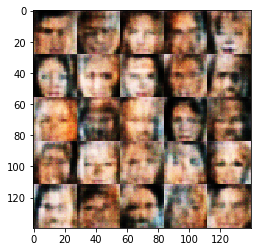

Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 1.5570


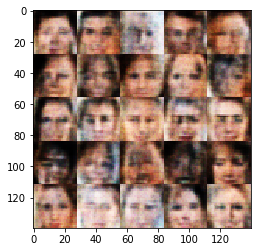

Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.6604
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.0479


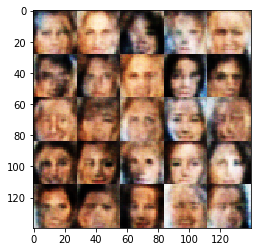

Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.6496... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.5334


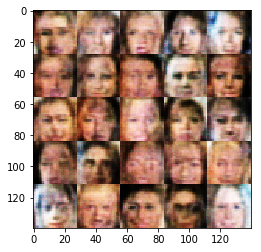

Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.3921
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 1.5688
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.1010


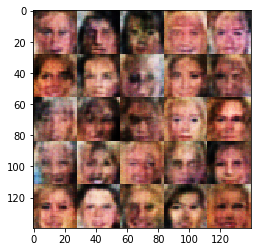

Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.5553


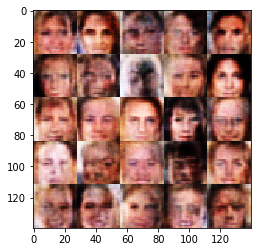

Epoch 1/1... Discriminator Loss: 2.0015... Generator Loss: 0.2405
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 1.3932


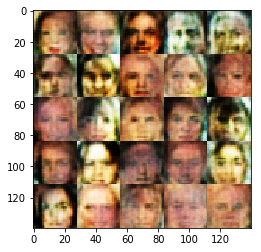

Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.0625


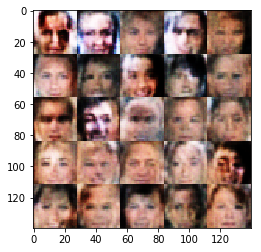

Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.5358
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.5262


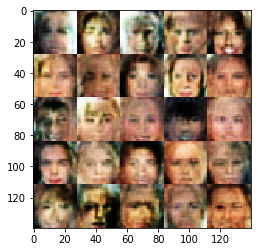

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.5420
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.3164
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.6050


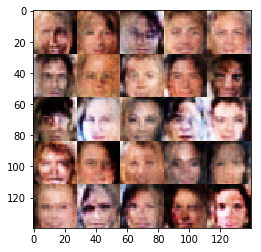

Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.6156
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.1501


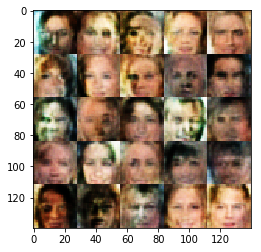

Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 2.0462
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.4640
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.6005


KeyboardInterrupt: 

In [30]:
batch_size = 100
z_dim = 28*28*3
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.